Задание 10. A/B тестирование.


Шаг 1. Изучите материалы лекционных и практических занятий по темам раздела 6. 

Шаг 2. Выполните A/B тестирование по предложенному датасету (алгоритм выполнения представлен в практическом занятии по теме 6.1).

Шаг 3. Опубликуйте файл расширения ipynb на платформе Odin.


Кейс: a/b-тест для мобильного приложения.

Имеется мобильное приложение для магазина по продаже продуктов питания. Выдвинута гипотеза о том, что смена шрифтов улучшит качество обслуживания по количеству клиентов, совершающих каждое событие. Для проверки этой гипотезы принято решение провести A/B-тест.   

Договорились принять решение по результатам A/B-теста. 
Пользователей разбили на 2 группы: 247 -- контрольная группа со старыми шрифтами (это другая группа, по сравнению с разобранной); 248 -- экспериментальная с новыми шрифтами. 

Описание данных

|Признак|Комментарий|
|--:|:--|
|`EventName`|название события|
|`DeviceIDHash`|уникальный идентификатор пользователя|
|`EventTimestamp`|время события|
|`ExpId`|номер группы|

Инструкция по выполнению проекта

Шаг 1. Загрузите данные
- Знакомство с данными;
- Корректность a/b-теста.

Шаг 2. Подготовьте данные
- Корректировка заголовков;
- Типы данных;
- Аномалии пропуски. 

Шаг 3. EDA
- Cколько всего событий?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Период теста: максимальная и минимальная даты; гистограмма по дате и количеству событий.

Шаг 4. Анализ воронки событий
- Распределение событий: какие события и в каком количестве.
- Сколько пользователей совершали каждое из этих событий?
- Постройте воронку событий: какая доля пользователей проходит на следующий шаг воронки. На каком шаге теряете больше всего пользователей?
Какая доля пользователей доходит от первого события до оплаты?

Шаг 5. Анализ результатов эксперимента
- Сколько пользователей в каждой группе?
- Посчитайте долю пользователей, совершивших каждое из событий. 
- Проверьте гипотезу о наличие значимых отличий по результатам теста.

In [1]:
# Подключение библиотек

import pandas as pd
import numpy as np

import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
colors =["#ef476f","#ffd166","#06d6a0","#118ab2","#073b4c"]
sns.set_palette(sns.color_palette(colors))
import re
import warnings
warnings.filterwarnings("ignore") 
from scipy import stats as st
import math as mth

In [3]:
#Загрузка данных

df = pd.read_csv('/content/ab_test_home.csv')
df 

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
1,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
2,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
3,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248
4,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247
...,...,...,...,...
163817,MainScreenAppear,2300292234025330845,2019-08-07 21:05:57,247
163818,MainScreenAppear,5317814261427487562,2019-08-07 21:09:22,248
163819,OffersScreenAppear,5317814261427487562,2019-08-07 21:09:27,248
163820,OffersScreenAppear,5317814261427487562,2019-08-07 21:10:08,248


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163822 entries, 0 to 163821
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       163822 non-null  object
 1   DeviceIDHash    163822 non-null  int64 
 2   EventTimestamp  163822 non-null  object
 3   ExpId           163822 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 5.0+ MB


In [5]:
# анализ распределения клинетов по группам теста -- должно быть примерно одинаково
df.ExpId.value_counts()

248    85747
247    78075
Name: ExpId, dtype: int64

In [6]:
# проверим, чтобы одни и те же пользователи не входили одновременно в группу A -- 247 и  B -- 248

#удаляем дубли 
df.drop_duplicates(keep = False, inplace = True )

In [7]:
# пытаемся установить общих пользователей для групп
# воспользуемся множествами: 

# множество клиентов контрольной группы    
A = set(df[df.ExpId == 247].DeviceIDHash.unique())

# множество клиентов экспериментальной группы
B = set(df[df.ExpId== 248].DeviceIDHash.unique())

# пересечение: если итоговое множество пустое, то общих клиентов нет.
A.intersection(B)

set()

In [8]:
# Предобработка: корректировка заголовков и типов 

#корректировка заголовков
df.rename(columns = {'EventName' : 'event_name', 
                     'DeviceIDHash' : 'device_id',
                     'EventTimestamp' : 'event_time',
                     'ExpId' : 'group_id'}, inplace = True) 

In [9]:
#корректировка типов
df['event_time'] = pd.to_datetime(df['event_time']) 
                                  

In [10]:
# проверим дату
df.head(2)

,event_name,device_id,event_time,group_id
0,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
1,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248


In [11]:
#эксперимент по умеьшению размер занимаемой памяти
df = df.astype({'group_id' : 'str', 
           'device_id' : 'str'})

In [12]:
#он провалился
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163279 entries, 0 to 163821
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  163279 non-null  object        
 1   device_id   163279 non-null  object        
 2   event_time  163279 non-null  datetime64[ns]
 3   group_id    163279 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 6.2+ MB


In [13]:
#Поиск аномалий -- по количеству сессий

df.groupby('device_id').agg(count_device_id = ('device_id', 'count')).\
reset_index().\
sort_values(by = 'count_device_id', ascending = False)


,device_id,count_device_id
3224,6304868067479728361,2306
2167,4623191541214045580,1765
3571,6932517045703054087,1432
433,1754140665440434215,1220
2233,4713748699910253089,824
...,...,...
2109,4530866328707864508,1
1340,3336727186673646149,1
4240,7962370797737085275,1
4256,7982248574455189469,1


Шаг 3. EDA

- Cколько всего событий?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Период теста: максимальная и минимальная даты; гистограмма по дате и количеству событий.

In [14]:
#Cколько всего событий?

print("""
Всего событий {}.
Уникальных событий {}: {}.
Уникальных пользователей {}.
На одного пользователя в среднем приходится {} события. 
""".format(df.shape[0], 
           df.event_name.nunique(), 
           ', '.join(df.event_name.unique()),
           df.device_id.nunique(),
           int(df.shape[0] / df.device_id.nunique())
           ))


Всего событий 163279.
Уникальных событий 5: PaymentScreenSuccessful, CartScreenAppear, MainScreenAppear, Tutorial, OffersScreenAppear.
Уникальных пользователей 5062.
На одного пользователя в среднем приходится 32 события. 



In [15]:
# Период теста: максимальная и минимальная даты; 
# гистограмма по дате и количеству событий.

print("""
Тест начался {}.
Тест закончился {}.
""".format(df.event_time.min(), 
           df.event_time.max()
           )
)


Тест начался 2019-07-25 11:28:47.
Тест закончился 2019-08-07 21:12:25.



Перед нами логи за период с 2019-07-25 11:28:47 по 2019-08-07 21:12:25.

Всего событий в логе 163279.

Всего пользователей в логе 5062.

В среднем на пользователя приходится 20 событий.


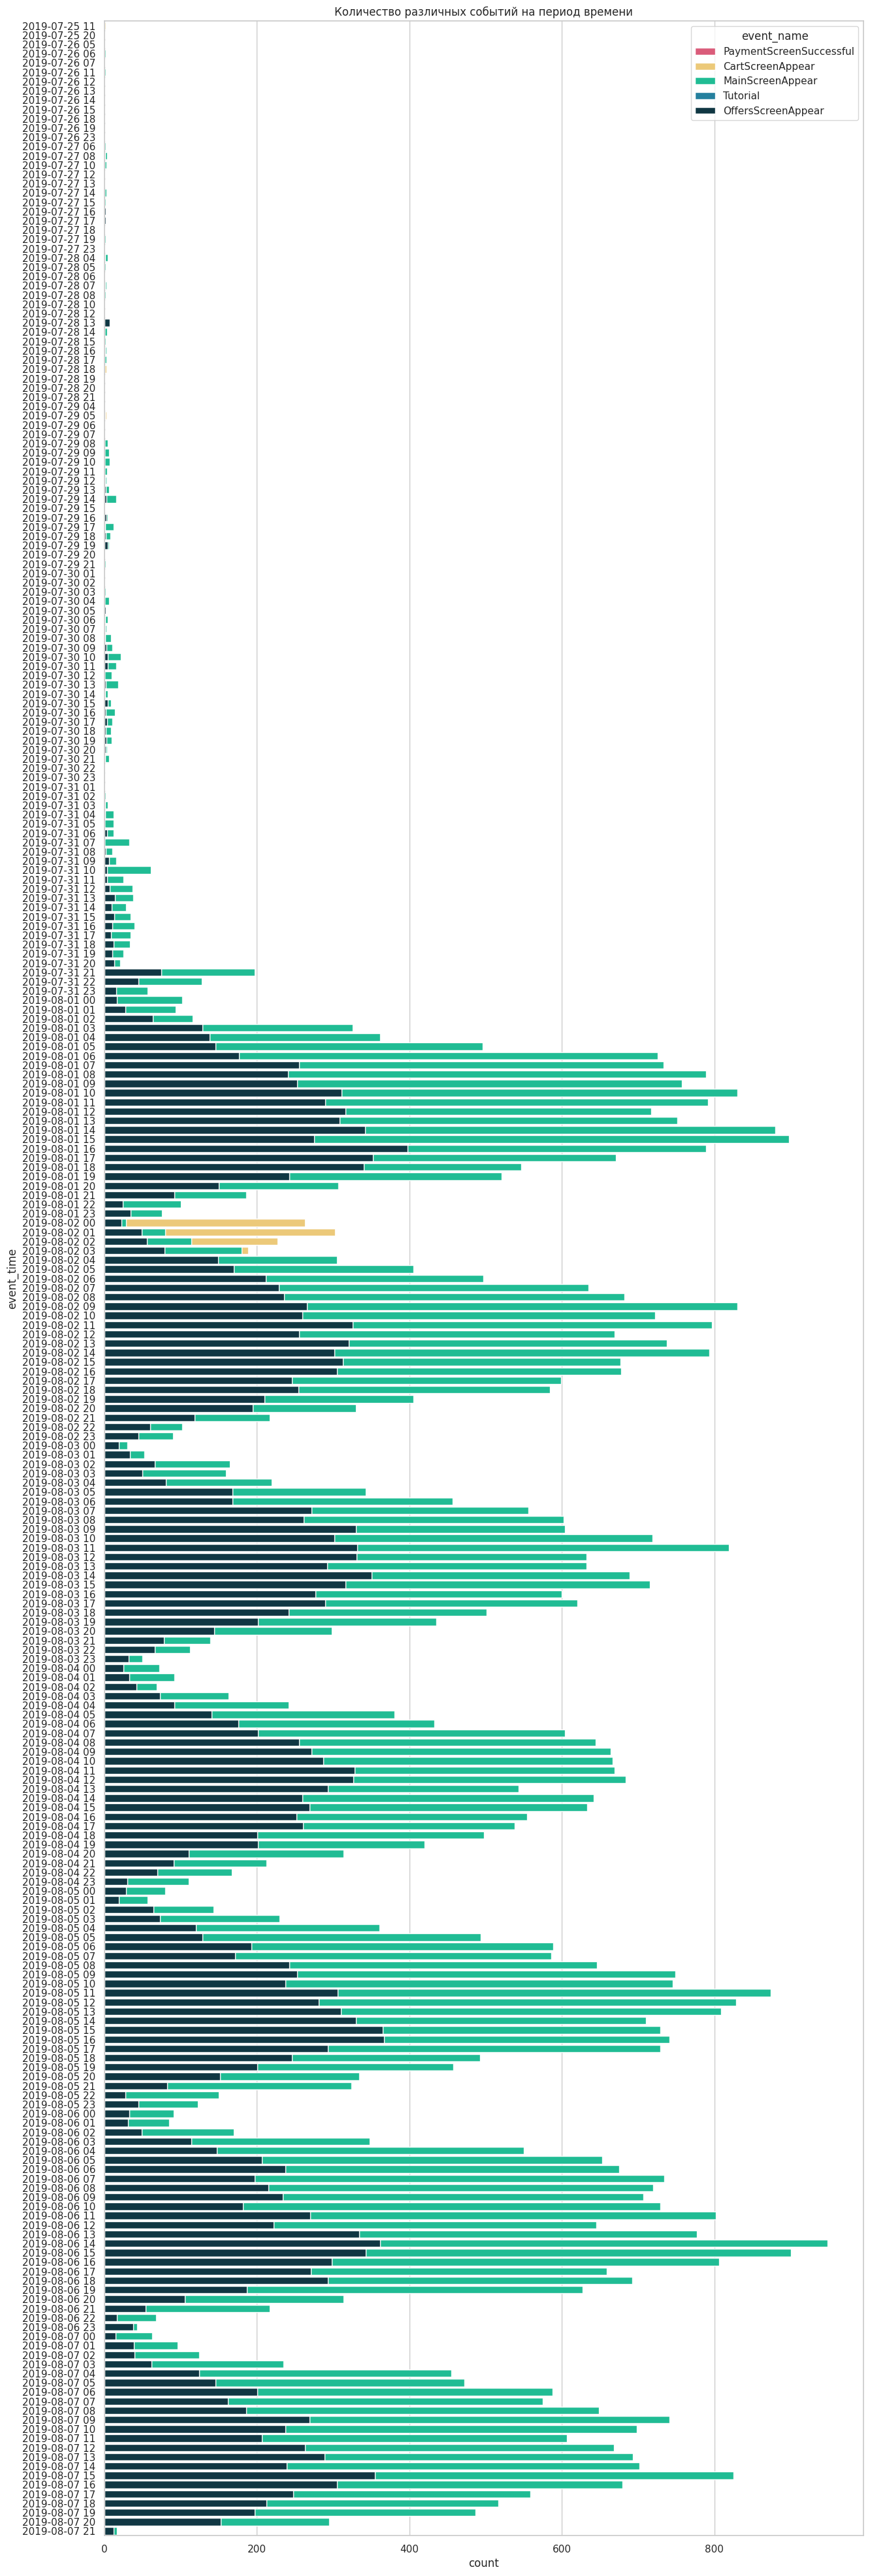

In [16]:
print('Перед нами логи за период с {} по {}.'.format(df['event_time'].min(), df['event_time'].max()))
print('')
print('Всего событий в логе {}.'.format(df['device_id'].count()))
print('')
print('Всего пользователей в логе {}.'.format(df['device_id'].nunique()))
print('')
print('В среднем на пользователя приходится {} событий.'
      .format(int(df.groupby('device_id')['event_name'].agg('count').median())))
plt.figure(figsize=(15, 50))
ax = sns.countplot(y=df['event_time'].dt.strftime('%Y-%m-%d %H'), hue='event_name', data=df, dodge=False)
ax.set_title('Количество различных событий на период времени')
plt.show()

In [17]:
# гистограмма по дате и количеству событий

df['event_date'] = df['event_time'].dt.date

In [18]:
df[['event_time', 'event_date']]

,event_time,event_date
0,2019-07-25 11:28:47,2019-07-25
1,2019-07-25 11:28:47,2019-07-25
2,2019-07-25 11:48:42,2019-07-25
3,2019-07-25 11:48:43,2019-07-25
4,2019-07-25 20:31:42,2019-07-25
...,...,...
163817,2019-08-07 21:05:57,2019-08-07
163818,2019-08-07 21:09:22,2019-08-07
163819,2019-08-07 21:09:27,2019-08-07
163820,2019-08-07 21:10:08,2019-08-07


In [19]:
df_count_event_day = df.groupby('event_date').agg(count_event_day = ('event_name', 'count')).\
reset_index()

In [20]:
df_count_event_day

,event_date,count_event_day
0,2019-07-25,5
1,2019-07-26,17
2,2019-07-27,31
3,2019-07-28,72
4,2019-07-29,129
5,2019-07-30,282
6,2019-07-31,1409
7,2019-08-01,24531
8,2019-08-02,24576
9,2019-08-03,22666


In [21]:
df_count_event_day

,event_date,count_event_day
0,2019-07-25,5
1,2019-07-26,17
2,2019-07-27,31
3,2019-07-28,72
4,2019-07-29,129
5,2019-07-30,282
6,2019-07-31,1409
7,2019-08-01,24531
8,2019-08-02,24576
9,2019-08-03,22666


Text(0.5, 1.0, '')

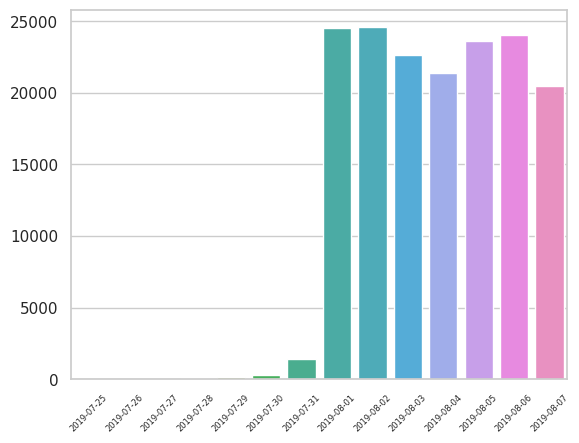

In [22]:
ax = sns.barplot(data = df_count_event_day, 
            x = 'event_date',
            y = 'count_event_day')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 6);
plt.xlabel('')
plt.ylabel('')
plt.title('')
#plt.legend()
#plt.show()

In [23]:
# с учетом результатов по количеству событий в день
# оставим в выборке данные с 2019-08-01

df_ok = df[df.event_date >= dt.datetime(2019, 8, 1).date()]

In [24]:
# проверим соотношение пользователей по группам  
df_ok.group_id.value_counts()

248    84420
247    76914
Name: group_id, dtype: int64

Шаг 4. Анализ воронки событий

- Распределение событий: какие события и в каком количестве.
- Сколько пользователей совершали каждое из этих событий?
- Постройте воронку событий: какая доля пользователей проходит на следующий шаг воронки. На каком шаге теряете больше всего пользователей? Какая доля пользователей доходит от первого события до оплаты?

In [25]:
df_ok.columns

Index(['event_name', 'device_id', 'event_time', 'group_id', 'event_date'], dtype='object')

In [26]:
#Распределение событий: какие события и в каком количестве.

df_ok.groupby('event_name').agg(count_event = ('device_id', 'count')).\
reset_index().\
sort_values(by = 'count_event', ascending = False)

,event_name,count_event
1,MainScreenAppear,79582
2,OffersScreenAppear,31555
0,CartScreenAppear,27572
3,PaymentScreenSuccessful,21954
4,Tutorial,671


In [27]:
#Сколько уникальных пользователей совершали каждое из этих событий?
events_by_users = df.groupby('event_name').agg({'device_id': 'nunique'}).sort_values('device_id', ascending=False).reset_index()
events_by_users.columns = ['event_name', 'cnt_users']
events_by_users

,event_name,cnt_users
0,MainScreenAppear,4983
1,OffersScreenAppear,3068
2,CartScreenAppear,2479
3,PaymentScreenSuccessful,2343
4,Tutorial,568


In [28]:
df_ok.device_id.nunique()

5050

Шаг 5. Анализ результатов эксперимента

Сколько пользователей в каждой группе?
Посчитайте долю пользователей, совершивших каждое из событий.
Проверьте гипотезу о наличие значимых отличий по результатам теста.





In [29]:
#Сколько пользователей в каждой группе
df.groupby('group_id').agg({'device_id': 'nunique'})

,device_id
group_id,
247,2520
248,2542


In [30]:
events_by_users = df.groupby('event_name').agg({'device_id': 'nunique'}).sort_values('device_id', ascending=False).reset_index()
events_by_users.columns = ['event_name', 'n_users']
events_by_users

,event_name,n_users
0,MainScreenAppear,4983
1,OffersScreenAppear,3068
2,CartScreenAppear,2479
3,PaymentScreenSuccessful,2343
4,Tutorial,568


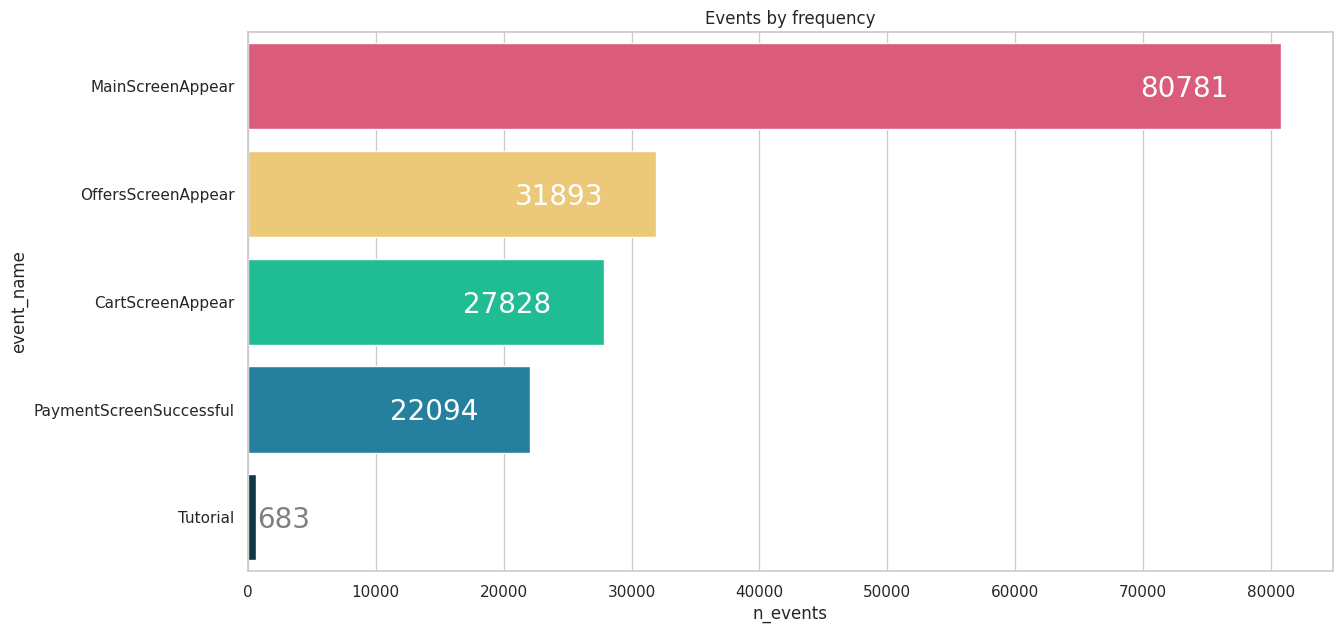

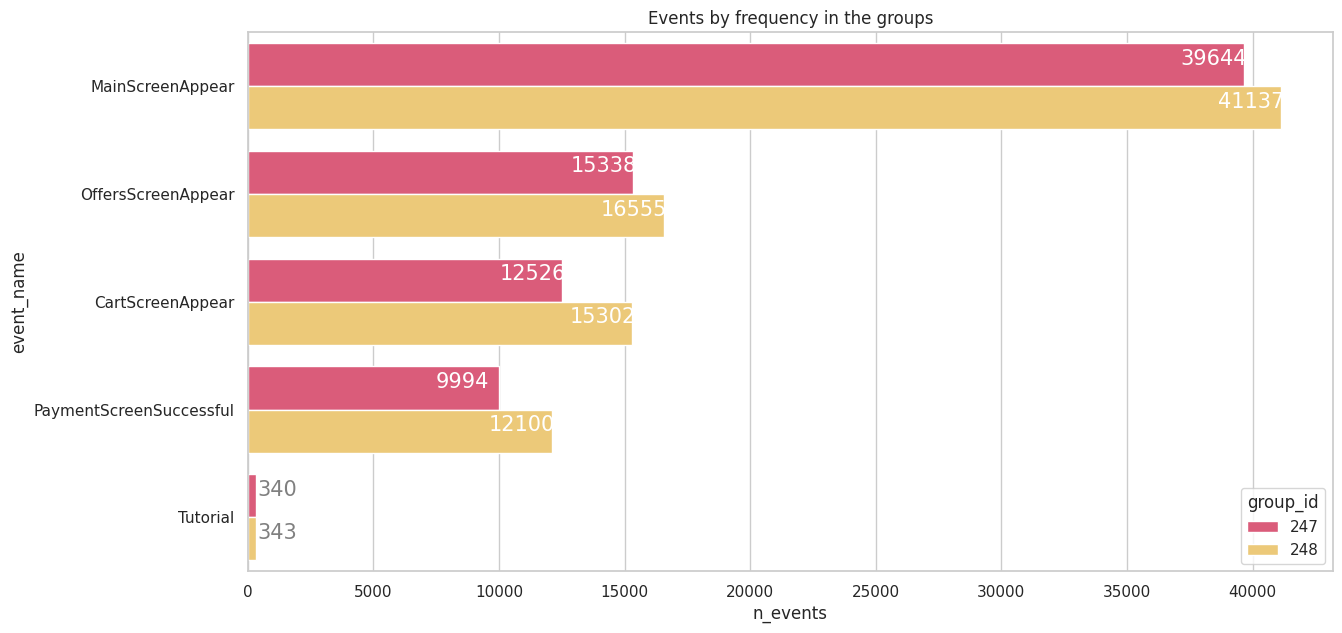

In [31]:
events = df.groupby('event_name')['device_id'].agg(['count', 'nunique']).reset_index()
events.columns =['event_name', 'n_events', 'n_users']
n_users = {'all': df['device_id'].nunique(), 
           247: df[df['group_id']==247]['device_id'].nunique(),
           248: df[df['group_id']==248]['device_id'].nunique(),
           '247+248': df[(df['group_id']==247) | (df['group_id']==248)]['device_id'].nunique()}
plt.figure(figsize=(14, 7))
order = events.sort_values('n_events', ascending=False).reset_index(drop=True)['event_name']
ax = sns.barplot(y='event_name', x='n_events', order = order,  data=events)
ax.set_title('Events by frequency')
for i in ax.patches:
    if i.get_width() > 20000:
        ax.text(i.get_width()-11000, i.get_y()+0.5, 
                str(int(i.get_width())), fontsize=20, color='white')
    else:
        ax.text(i.get_width()+30, i.get_y()+0.5, 
                str(int(i.get_width())), fontsize=20, color='grey')
plt.show()

event_pivot=df.pivot_table(index=['event_name','group_id'], values='device_id', aggfunc=['count', 'nunique']).reset_index()
event_pivot.columns= ['event_name','group_id', 'n_events', 'n_users']

plt.figure(figsize=(14, 7))
ax = sns.barplot(y='event_name', x='n_events', order = order, hue='group_id', data=event_pivot)
ax.set_title('Events by frequency in the groups')
for i in ax.patches:
    if i.get_width() > 9000:
        ax.text(i.get_width()-2500, i.get_y()+0.2, 
                str(int(i.get_width())), fontsize=15, color='white')
    else:
        ax.text(i.get_width()+30, i.get_y()+0.2, 
                str(int(i.get_width())), fontsize=15, color='grey')
plt.show()

Комментарий: Самое частое событие это появление основного экрана(MainScreenAppear) случалось 80781 раз. Второе по популярности событие это появление экрана с каталогом продуктов(OffersScreenAppear) случалось 31893 раз. Третье по популярности событие это появление экрана с корзиной(CartScreenAppear) случалось 27828 раза. Четвёртое по популярности событие это появление экрана с успешной оплатой(PaymentScreenSuccessful) случалось 22094 раз. Пятое по популярности событие это открытие руководства пользователя(Tutorial) случалось 683 раз.

In [32]:
#Посчитайте долю пользователей, совершивших каждое из событий
events_by_users['share'] = events_by_users['n_users'] / df['device_id'].nunique()
events_by_users.style.format({'share':'{:.2%}'})

,event_name,n_users,share
0,MainScreenAppear,4983,98.44%
1,OffersScreenAppear,3068,60.61%
2,CartScreenAppear,2479,48.97%
3,PaymentScreenSuccessful,2343,46.29%
4,Tutorial,568,11.22%


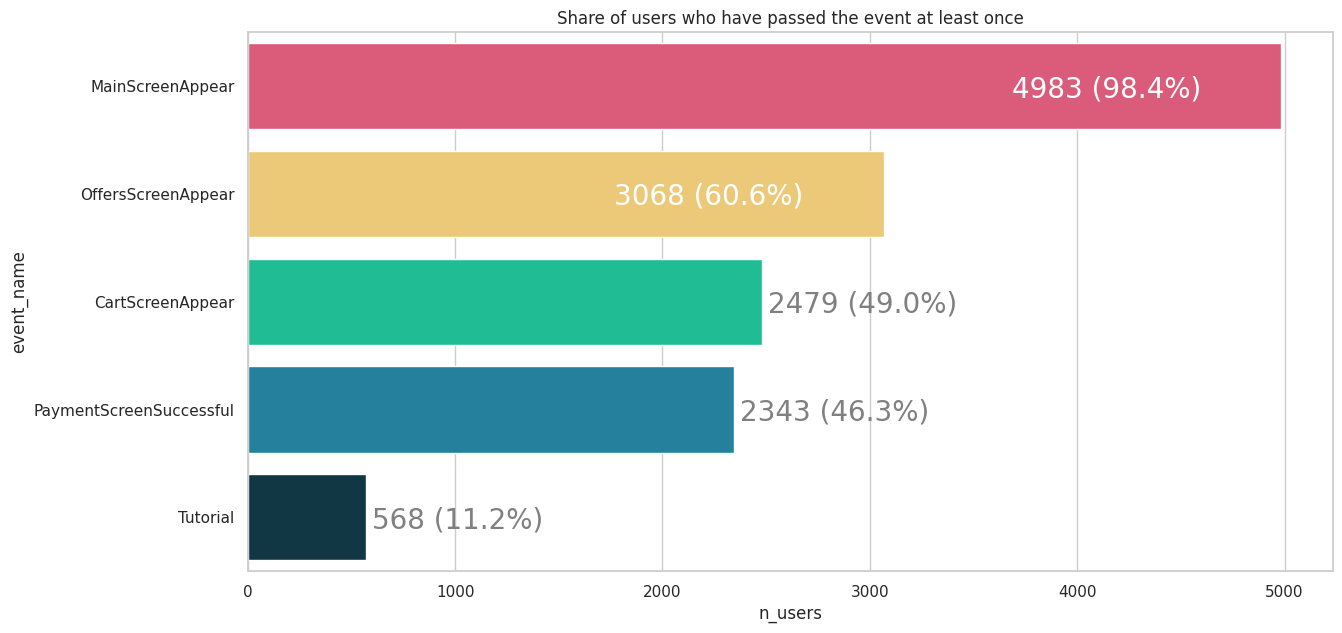

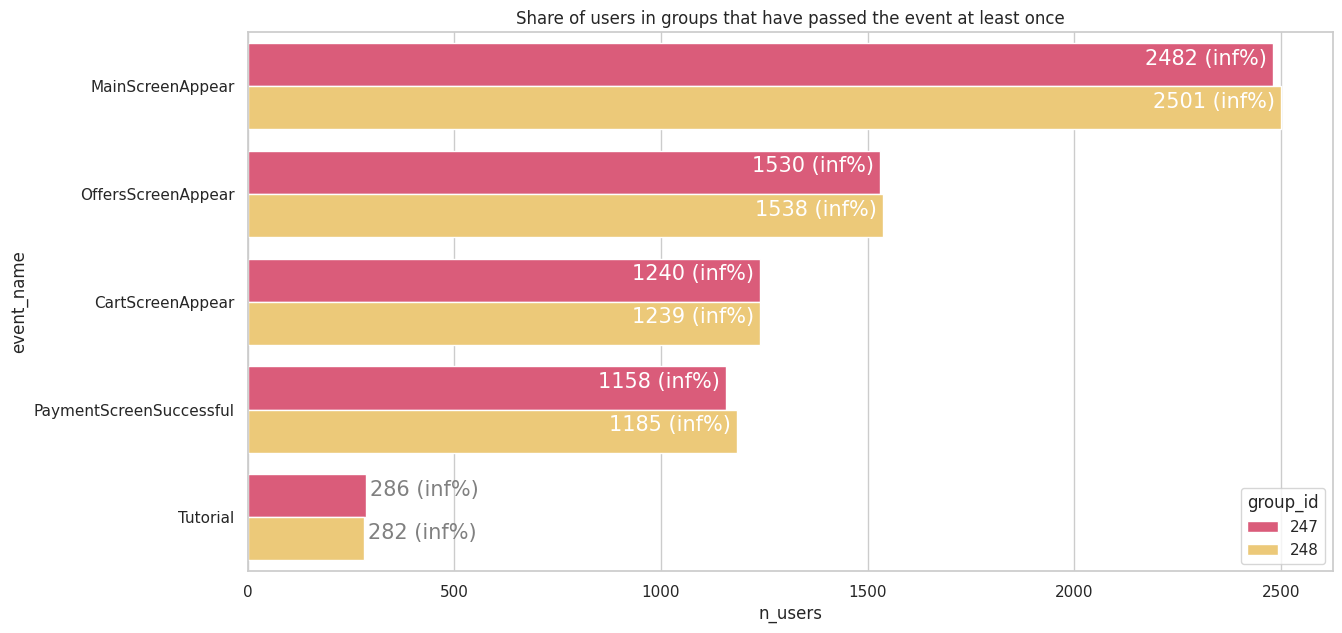

In [33]:
plt.figure(figsize=(14, 7))
ax = sns.barplot(y='event_name', x='n_users', order = order,  data=events)
ax.set_title('Share of users who have passed the event at least once')
for i in ax.patches:
    if i.get_width() > 3000:
        ax.text(i.get_width()-1300, i.get_y()+0.5, 
            str(int(i.get_width()))+' ({:.1%})'.format(i.get_width() / n_users['all']), fontsize=20, color='white')
    else:
        ax.text(i.get_width()+30, i.get_y()+0.5, 
            str(int(i.get_width()))+' ({:.1%})'.format(i.get_width() / n_users['all']), fontsize=20, color='grey')
plt.show()

plt.figure(figsize=(14, 7))
ax = sns.barplot(y='event_name', x='n_users', order = order, hue='group_id', data=event_pivot)
ax.set_title('Share of users in groups that have passed the event at least once')
for i,v in enumerate(ax.patches):
    if i < 5:
        if v.get_width() > 1000:
            ax.text(v.get_width()-310, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / n_users[247]),
                    fontsize=15, color='white')
        else:
            ax.text(v.get_width()+10, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / n_users[247]),
                    fontsize=15, color='grey')
    if 5 <= i < 10:
        if v.get_width() > 1000:
            ax.text(v.get_width()-310, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / n_users[247]),
                    fontsize=15, color='white')
        else:
            ax.text(v.get_width()+10, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / n_users[248]),
                    fontsize=15, color='grey')
    if i >= 10:
        if v.get_width() > 1000:
            ax.text(v.get_width()-310, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / n_users[248]),
                    fontsize=15, color='white')
        else:
            ax.text(v.get_width()+10, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / n_users[248]),
                    fontsize=15, color='grey')
plt.show()

98% пользователей попадают на главный экран, почти 50% на экран оплаты и 47% на экран "оплата прошла успешно". Значит около 3% пользователей при оплате заказа где-то теряется. В любом случае на первый взгляд показатель конверсии довольно высок.

Комментарий:
4983 пользователя хотя бы раз открывали главную страницу приложения(MainScreenAppear) это 98,5% всех пользователей.
Возможно оставшиеся пользователи не смогли попасть на главную страницу из-за ошибок/некорректного отображения.
3068 пользователей хотя бы раз открывали страницу с каталогом товаров(OffersScreenAppear) это 61% всех пользователей.
39% пользователей не увидели даже каталог товаров стоит выяснить причину, возможно приложение не на всех устройствах работает корректно.
2479 пользователей хотя бы раз открывали корзину(CartScreenAppear) это 49,6% всех пользователей.
2343 пользователей хотя бы раз попадали на страницу с успешной оплатой(PaymentScreenSuccessful) это 47% всех пользователей.
568 пользователя хотя бы раз открывали руководство пользователя(Tutorial) это 11,2% всех пользователей.